In [1]:
import matplotlib.pyplot as plt
from IPython.display import Image
import pickle
import time
import numpy
import yt.units as u
import numpy
loc_pwd = ""
def save_obj(obj, name ):
    with open(loc_pwd+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(loc_pwd + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
import sys
sys.path.append("../cvdls_examples/9species_cooling") 
sys.path.append("../cvspils_examples/9species_cooling") 
sys.path.append("../be_chem_solve_examples/9species_cooling/") 

from generate_dls_cooling_network import run_cvdls
from generate_cvspils_cooling_network import run_cvspils
from generate_bechem_cooling_network import run_bechem
%matplotlib inline

import os
os.environ['YT_DEST'] = '/home/kwoksun2/anaconda2/pkgs/yt-3.3.5-np111py27_2/'
import numpy as np
from dengo.chemical_network import \
    ChemicalNetwork, \
    reaction_registry, \
    cooling_registry, species_registry
import dengo.primordial_rates, dengo.primordial_cooling
from dengo.chemistry_constants import tiny, kboltz, mh
import time

 using cli
 using CLI for selections


In [2]:
def Init_values(temperature, density, n_species = 9, cooling=True):
    """ Create a initial value dictionary,
        for a given temperature, density, number of species
    Args:
        temperature -- in Kelvin
        density     -- in amu / cm**3
        n_species   -- number of species (6/9)
        cooling

    Returns:
        init_values: initial value dictionary with
                     self-consistent energy/ electron density
        primordial : chemical_network classes

    """

    # initialize and setup the network
    dengo.primordial_rates.setup_primordial()
    primordial = ChemicalNetwork()
    primordial.threebody = 4

    if n_species == 9:
        for i in range(22):
            try:
                primordial.add_reaction("k{0:02d}".format(i+1))
            except:
                pass
    else:
        for i in range(6):
            try:
                primordial.add_reaction("k{0:02d}".format(i+1))
            except:
                pass

    # the temperature array required to interpolates the rates
    primordial.init_temperature((1e0, 1e5))

    tiny = 1.0e-20

    # init_array are is in fractional abundances
    init_values = dict()
    density = numpy.array([density])
    if n_species == 6:
        # 6-species model
        init_values["He_1"]    = density * (1.0 - 0.76)
        init_values["He_2"]    = np.array([tiny])
        init_values["He_3"]    = np.array([tiny])
        init_values["H_1"]     = density *  (0.76)
        init_values['H_2']     = np.array([tiny]) 
    else:
        # 9-species model
        init_values["He_1"]    = density * (1.0 - 0.76) 
        init_values["He_2"]    = density *np.array([tiny])
        init_values["He_3"]    = density *np.array([tiny])
        init_values["H_1"]     = density *  (0.76)
        init_values['H_2']     = density *np.array([tiny])

        init_values["H_m0"]    = density *np.array([tiny])
        init_values["H2_1"]    = density *np.array([tiny])
        init_values["H2_2"]    = density *np.array([tiny])

    # now everything in mass density
    init_values['de'] = primordial.calculate_free_electrons(init_values)
    # one signle value: again mass density
    init_values['density'] = primordial.calculate_total_density(init_values)

    num_den = {}
    for sp in primordial.required_species:
        try:
            num_den[sp.name] = init_values[sp.name]/ sp.weight
        except:
            pass

    # set up initial temperatures values used to define ge
    init_values['T'] = numpy.array([temperature])

    # calculate gammaH2
    x = 6100.0/temperature
    expx = numpy.exp(x)
    gammaH2 = 2.0 / (5.0 + 2.0*x*x*expx / (expx - 1 )**2.0 ) + 1

    gamma_factor = primordial.gamma_factor().subs(num_den).subs({'gammaH2': gammaH2 , 'gamma': 5./3.,'T': temperature })
    print(gamma_factor)
    ge  = ((temperature *  kboltz) *gamma_factor
                         / (init_values['density'] * mh  ))

    T = init_values['density']*ge*mh / kboltz / gamma_factor
    print(T-temperature)
    init_values['ge'] = numpy.array( [numpy.float64(ge)] )

    if cooling:
        for cooling_action in cooling_registry:
            k = cooling_registry[cooling_action]
            if (k.species).issubset( primordial.required_species ):
                print("adding:", k.name, k.equation)
                primordial.add_cooling(cooling_action)
                print('---------------------------')
    return init_values, primordial

In [3]:
from pygrackle import \
    FluidContainer, \
    chemistry_data, \
    evolve_constant_density

from pygrackle.utilities.physical_constants import \
    mass_hydrogen_cgs, \
    sec_per_Myr, \
    cm_per_mpc, \
    mass_electron_cgs

tiny_number = 1e-20
import sys

def run_grackle(density, initial_temperature, final_time):
    current_redshift = 0.

    # Set initial values


    # Set solver parameters
    my_chemistry = chemistry_data()
    my_chemistry.use_grackle = 1
    my_chemistry.with_radiative_cooling = 1
    my_chemistry.primordial_chemistry = 2
    my_chemistry.three_body_rate = 4
    my_chemistry.metal_cooling = 0
    my_chemistry.UVbackground = 0
    my_chemistry.self_shielding_method = 0
    my_chemistry.H2_self_shielding = 0
    grackle_dir = "/home/kwoksun2/grackle_install/"
    my_chemistry.grackle_data_file = os.sep.join(
        [grackle_dir, "input", "CloudyData_UVB=HM2012.h5"])
    
    my_chemistry.cie_cooling = 1
    # Set units
    my_chemistry.comoving_coordinates = 0 # proper units
    my_chemistry.a_units = 1.0
    my_chemistry.a_value = 1. / (1. + current_redshift) / \
        my_chemistry.a_units
    my_chemistry.density_units = 1.66053904e-24 #mass_hydrogen_cgs # rho = 1.0 is 1.67e-24 g
    my_chemistry.length_units = cm_per_mpc         # 1 Mpc in cm
    my_chemistry.time_units = sec_per_Myr          # 1 Myr in s
    my_chemistry.velocity_units = my_chemistry.a_units * \
        (my_chemistry.length_units / my_chemistry.a_value) / \
        my_chemistry.time_units

    rval = my_chemistry.initialize()

    fc = FluidContainer(my_chemistry, 1)
    fc["density"][:] = density
    if my_chemistry.primordial_chemistry > 0:
        fc["HI"][:] = 0.76 * fc["density"]
        fc["HII"][:] = tiny_number * fc["density"]
        fc["HeI"][:] = (1.0 - 0.76) * fc["density"]
        fc["HeII"][:] = tiny_number * fc["density"]
        fc["HeIII"][:] = tiny_number * fc["density"]
    if my_chemistry.primordial_chemistry > 1:
        fc["H2I"][:] = tiny_number * fc["density"] 
        fc["H2II"][:] = tiny_number * fc["density"]
        fc["HM"][:] = tiny_number * fc["density"]
        fc["de"][:] = 2e-4 * mass_electron_cgs / mass_hydrogen_cgs * fc["density"]
            # tiny_number * fc["density"]
    if my_chemistry.primordial_chemistry > 2:
        fc["DI"][:] = 2.0 * 3.4e-5 * fc["density"]
        fc["DII"][:] = tiny_number * fc["density"]
        fc["HDI"][:] = tiny_number * fc["density"]
    if my_chemistry.metal_cooling == 1:
        fc["metal"][:] = 0.1 * fc["density"] * \
          my_chemistry.SolarMetalFractionByMass

    fc["x-velocity"][:] = 0.0
    fc["y-velocity"][:] = 0.0
    fc["z-velocity"][:] = 0.0

    fc["energy"][:] = initial_temperature / \
        fc.chemistry_data.temperature_units
    fc.calculate_temperature()
    fc["energy"][:] *= initial_temperature / fc["temperature"]

    # timestepping safety factor
    safety_factor = 0.001
    
    tic = time.time()
    # let gas cool at constant density
    data = evolve_constant_density(
        fc, final_time=final_time,
        safety_factor=safety_factor)
    toc = time.time()

    # convert grackle language to dengo language
    name_map_dict = { 'HI':'H_1',
              'HII':'H_2',
              'HeI':'He_1',
              'HeII':'He_2',
              'HeIII':'He_3',
              'H2I' : 'H2_1',
              'H2II': 'H2_2',
              'HM' : 'H_m0',
                'de':'de',
                'temperature':'T',
                'time': 't',
                'energy':'ge'}

    weight_map_dict = { 'HI':1.00794,
              'HII':1.00794,
              'HeI':4.002602,
              'HeII':4.002602,
              'HeIII':4.002602,
               'H2II': 2.01588,
               'H2I' : 2.01588,
               'HM' : 1.00794,
                'de':1.00794,
                  'time': 1.0,
                  'temperature': 1.0,
                  'energy': 1.0}

    data_grackle = {}


    for key in name_map_dict.keys():
        key_dengo = name_map_dict[key]
        if key_dengo in ["t","T"]:
            data_grackle[key_dengo] = data[key].value
        else:
            data_grackle[key_dengo] = data[key].value / weight_map_dict[key] / u.amu_cgs.value
    
    return data_grackle, toc-tic

In [4]:
def calc_fftime(den):
    mu = 1.0
    rho = mu* u.mass_hydrogen *den *(u.cm**-3)
    tff = numpy.sqrt(1.0 / u.G / rho).in_units('s')
    return tff.v

In [5]:
density = 1e10
initial_temperature = 3000.0
final_time = calc_fftime(density)
final_time = 3.15e-3
init, primordial = Init_values(initial_temperature, 
                               density, n_species = 9, 
                               cooling=True);

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

In [8]:
density = 1e13
initial_temperature = 3000.0
final_time = calc_fftime(density)*1e-11

final_time_Myr = u.second.in_units('Myr').v * final_time

# run grackle
grackle_data, run_time_grackle = run_grackle(density, initial_temperature, final_time_Myr)

init, primordial = Init_values(initial_temperature, 
                               density, n_species = 9, 
                               cooling=True);

# # run our solver
_, cvdls_data, run_time_cvdls = run_cvdls( initial_temperature, 
                                          density, final_time, 
                                          init=init, primordial=primordial)
# _, bechem_data, run_time_bechem = run_bechem( initial_temperature, 
#                                              density, final_time, 
#                                             init=init, primordial=primordial)
# _, cvspils_data, run_time_cvspils = run_cvspils( initial_temperature, 
#                                                 density, final_time, 
#                                                init=init, primordial=primordial)

Evolve constant density - t: 0.000000e+00 yr, rho: 1.660539e-11 g/cm^3, T: 3.000000e+03 K.
Evolve constant density - t: 2.998229e-13 yr, rho: 1.660539e-11 g/cm^3, T: 3.000000e+03 K.
Evolve constant density - t: 5.996457e-13 yr, rho: 1.660539e-11 g/cm^3, T: 3.000000e+03 K.
Evolve constant density - t: 8.994686e-13 yr, rho: 1.660539e-11 g/cm^3, T: 3.000000e+03 K.
Evolve constant density - t: 1.199291e-12 yr, rho: 1.660539e-11 g/cm^3, T: 3.000000e+03 K.
Evolve constant density - t: 1.499114e-12 yr, rho: 1.660539e-11 g/cm^3, T: 3.000000e+03 K.
Evolve constant density - t: 1.798937e-12 yr, rho: 1.660539e-11 g/cm^3, T: 3.000000e+03 K.
Evolve constant density - t: 2.098760e-12 yr, rho: 1.660539e-11 g/cm^3, T: 3.000000e+03 K.
Evolve constant density - t: 2.398583e-12 yr, rho: 1.660539e-11 g/cm^3, T: 3.000000e+03 K.
Evolve constant density - t: 2.698406e-12 yr, rho: 1.660539e-11 g/cm^3, T: 3.000000e+03 K.
Evolve constant density - t: 2.998229e-12 yr, rho: 1.660539e-11 g/cm^3, T: 3.000000e+03 K.

H_2
H_1
de
He_1
He_2
He_3
H2_2
H2_1
H_m0
T


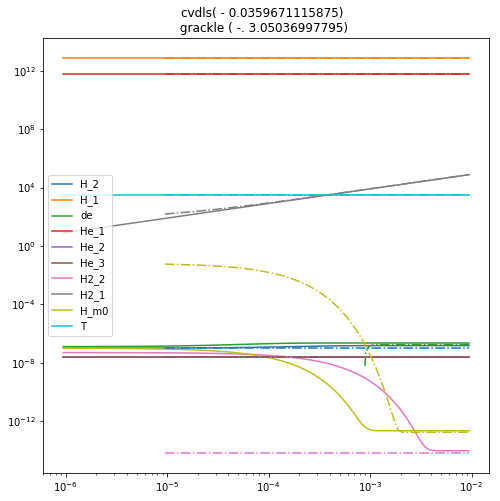

In [9]:
flag_cvdls = cvdls_data['successful']
t_cvdls = cvdls_data['t'][flag_cvdls]


# flag_bechem = bechem_data['successful']
# t_bechem = bechem_data['t'][flag_bechem]

# flag_cvspils = cvspils_data['successful']
# t_cvspils = cvspils_data['t'][flag_cvspils]

t_grackle = grackle_data['t']
flag_grackle = (t_grackle > 1e0)

plt.figure(figsize=(8,8))
for key in cvdls_data.keys():
    if key not in ['t', 'successful','dt','ge']:
        print(key)
        cvdls_d = cvdls_data[key][0][flag_cvdls]
        plt.semilogx( t_cvdls, cvdls_d,label=key)

#plt.gca().set_color_cycle(None)    
# for key in cvdls_data.keys():
#     if key not in ['t','successful','dt','ge']:
        
#         bechem_d = bechem_data[key][0][flag_bechem]
#         plt.semilogx( t_bechem, bechem_d, ls ='--')

# plt.gca().set_color_cycle(None)        
# for key in cvdls_data.keys():
#     if key not in ['t', 'successful','dt','ge']:
        
#         cvspils_d = cvspils_data[key][0][flag_cvspils]
#         plt.semilogx( t_cvspils, cvspils_d, ls= ':')
        
for key in cvdls_data.keys():
    if key not in ['t', 'successful','dt','ge']:
        
        grack_d = grackle_data[key]
        plt.loglog( t_grackle, grack_d, ls='-.')

plt.title('cvdls( - {})  \n grackle ( -. {})  '.format(run_time_cvdls, run_time_grackle) )

plt.legend()
plt.show()

In [ ]:
cvdls_d = cvdls_data['T'][0][flag_cvdls]   
3000.0/cvdls_d

In [ ]:
flag_cvdls = cvdls_data['successful']
grack_d = grackle_data['T']
# bechem_d = bechem_data['T'][0][flag_bechem]
cvdls_d = cvdls_data['T'][0][flag_cvdls]   
plt.semilogx(t_grackle,grack_d)
plt.semilogx(t_cvdls, cvdls_d, label='cvdls')
plt.legend()
plt.show()

In [ ]:
flag_cvdls = cvdls_data['successful']
t_cvdls = cvdls_data['t'][flag_cvdls]
t_grackle = grackle_data['t']

flag_grackle = (t_grackle > min(t_cvdls))

plt.figure(figsize=(8,8))
for key in grackle_data.keys():
    if key not in ['t','de','ge']:
        grack_d = grackle_data[key][flag_grackle]
        cvdls_d = cvdls_data[key][0][flag_cvdls]
        interp_cvdls_data = numpy.interp( t_grackle[flag_grackle], t_cvdls, cvdls_d )
        plt.semilogx( t_grackle[flag_grackle], grack_d/interp_cvdls_data,label=key)

plt.title('grackle (run_time = {}) / cvdls (run_time : {}) '.format(run_time_grackle,run_time_cvdls) )
plt.ylim(0.9,1.1)
plt.legend()
plt.show()

In [ ]:
plt.loglog( t_cvdls, cvdls_data['ge'][0][flag_cvdls] )
plt.semilogx( t_grackle, grackle_data['ge'], ls='-.')
plt.show()

In [ ]:
def conservation_of_M_e(data, flag_input=False):
    
    if flag_input:        
        flag = data['successful']
        size = len(data['t'][flag])
    else:
        flag = (data['t'] >= 0)
        size = len(data['t'])

        
    zeros = numpy.zeros((size))
    conserv_dict = {'H': zeros, 
                    'H2':zeros,
                    'He':zeros, 
                    'de':zeros, 
                    't': zeros, 
                    'de_':zeros}

    for key in data.keys():
        ele_charge = key.split('_')
        if ele_charge[0] in ['H', 'He']:

            name = ele_charge[0]
            if flag_input:
                conserv_dict[name] += data[key][0][flag]
            else:
                conserv_dict[name] += data[key][flag]
            try:
                charge = eval(ele_charge[1]) - 1
                if flag_input:
                    conserv_dict['de'] += charge*data[key][0][flag]
                else:
                    conserv_dict['de'] += charge*data[key][flag]
            except:
                if ele_charge[1][0] == 'm':             
                    charge = eval(ele_charge[1][1]) - 1
                    if flag_input:
                        conserv_dict['de'] += charge*data[key][0][flag]
                    else:
                        conserv_dict['de'] += charge*data[key][flag]
    
    conserv_dict['t'] = data['t'][flag]
    if flag_input:
        conserv_dict['de_'] = data['de'][0][flag]
    else:
        conserv_dict['de_'] = data['de'][flag]
    return conserv_dict

In [ ]:
conserv_dict_grackle = conservation_of_M_e(grackle_data)
conserv_dict_cvdls = conservation_of_M_e(cvdls_data, flag_input=True)

In [ ]:
t_gra = conserv_dict_grackle['t']
t_cvdls = conserv_dict_cvdls['t']

H_gra = conserv_dict_grackle['H']
H_cvdls = conserv_dict_cvdls['H']

H2_gra = conserv_dict_grackle['H2']
H2_cvdls = conserv_dict_cvdls['H2']

He_gra = conserv_dict_grackle['He']
He_cvdls = conserv_dict_cvdls['He']

de_gra = conserv_dict_grackle['de']
de_cvdls = conserv_dict_cvdls['de']

de__gra = conserv_dict_grackle['de_']
de__cvdls = conserv_dict_cvdls['de_']

plt.clf()
plt.plot( t_gra, (H_gra + 2.0*H2_gra)/(H_gra + 2.0*H2_gra)[0] ,color= 'r',ls='--')
plt.plot( t_cvdls, (H_cvdls + 2.0*H2_cvdls)/(H_cvdls + 2.0*H2_cvdls)[0] ,color= 'r',label='H')

plt.plot( t_gra, He_gra/He_gra[0]  ,color= 'b',ls='--')
plt.plot( t_cvdls, He_cvdls/He_cvdls[0] ,color= 'b',label='He')


net_charge_cvdls = (cvdls_data['H2_2'] + cvdls_data['H_2'] - cvdls_data['H_m0'] + cvdls_data["He_2"] + \
                2.0*cvdls_data["He_3"])/ cvdls_data["de"]

net_charge_gra = (grackle_data['H2_2'] + grackle_data['H_2'] - grackle_data['H_m0'] + grackle_data["He_2"] + \
                2.0*grackle_data["He_3"])/ grackle_data["de"]

t_cvdls = cvdls_data['t']
plt.plot( t_gra, net_charge_gra,color='g' ,ls='--')
plt.plot( t_cvdls, net_charge_cvdls[0],color='g',label='de')
plt.title('conservation')
plt.xlabel('time (s)')
plt.ylabel('fractional abundance')
plt.legend()
# plt.ylim(0.9,1.1)
plt.show()

In [ ]:
temperature = 100.0

In [ ]:
x = 6100.0/temperature
expx = numpy.exp(x)
gammaH2 = 2.0 / (5.0 + 2.0*x*x*expx / (expx - 1 )**2.0 ) + 1

In [ ]:
gammaH2

In [ ]:
temperature = numpy.logspace(0,5,100)
x = 6100.0/temperature
expx = numpy.exp(x)
gammaH2 = 2.0 / (5.0 + 2.0*x*x*expx / (expx - 1 )**2.0 ) + 1
plt.semilogx(temperature,1.0 / (gammaH2-1) )

In [ ]:
mh

In [ ]:
sp = species_registry['H2_1']

In [ ]:
expr = primordial.species_gamma(sp, temp=True)

In [ ]:
from sympy.utilities import lambdify

In [ ]:
fH2 = lambdify('T', expr)

In [ ]:
plt.plot(T, fH2(T))

In [ ]:
T = numpy.logspace(0,5,100)

In [ ]:
fH2(T)

In [ ]:
T

In [ ]:
a0 = 64.2416
a1 = -9.36334
a2 = -0.377266
a3 = 69.8091
a4 = 0.0493452
a5 = 2.28021
a6 = 0.115357
a7 = 0.114188
a8 = 2.90778
a9 = 0.689708

T0 = numpy.logspace(0,1,1024)

gamma_T = sympy.exp(-a0*T**a1)*(a2+T**-a3) \
            + a4*sympy.exp( - (T-a5)**2 / a6)\
            + a7*sympy.exp( -(T-a8)**2 / a9) \
            + 5./3.
T_array = numpy.logspace(0,6.5,1024)


In [ ]:
print(T_array)
plt.plot(T0, T_array)
plt.plot(T_array**(1./6.5), T_array ) 
plt.show()

In [ ]:
import sympy

In [ ]:
plt.semilogx(T_array, gamma_T)

T = primordial.T
plt.semilogx(primordial.T, gammaH2)
plt.ylim(1.2,1.7)

In [ ]:

T0 = numpy.logspace(0,6.5,1024)

gamma_T = numpy.exp(-a0*T0**a1)*(a2+T0**-a3) \
            + a4*numpy.exp( - (T0-a5)**2 / a6)\
            + a7*numpy.exp( -(T0-a8)**2 / a9) \
            + 5./3.
T_array = numpy.logspace(0,6.5,1024)

plt.semilogx(T_array, gamma_T)

T = primordial.T
plt.semilogx(primordial.T, gammaH2)
plt.ylim(1.2,1.7)

In [ ]:
gammaH2 = primordial.interpolate_species_gamma(sp)
dgammaH2_dT = primordial.interpolate_species_gamma(sp, deriv=True)

In [ ]:
# plt.semilogx(primordial.T,gammaH2)
plt.semilogx(primordial.T,dgammaH2_dT)
plt.show()

In [ ]:
primordial.temperature_calculation(derivative_dge_dT=True)

In [ ]:
import sympy

sp = species_registry['H2_1']
T = sympy.Symbol('T')

T = sympy.Symbol('T')
f = primordial.gamma_factor(temp=True) * sympy.Symbol('kb') * sympy.Symbol('T') \
        / sympy.Symbol('mh') / sympy.Symbol('density')
dge_dT = sympy.diff(f, T)


sym_fgamma = sympy.Function('gamma%s' %sp.name)(T)
sym_dfgamma = sympy.diff(sym_fgamma, T)
sym_gamma = sympy.Function('gamma%s' %sp.name)
dgamma = sympy.Symbol('dgamma%s_dT' %sp.name)
dge_dT = dge_dT.subs({sym_dfgamma: dgamma}).subs({sym_fgamma:sym_gamma})

In [ ]:
tmp = sympy.Symbol('tmp')

In [ ]:


dge_dT.subs({sym_fgamma:tmp}).subs({tmp: t})

In [ ]:
print(sym_fgamma)
sym_gamma

In [ ]:
(5.0 + 74420000.0*(numpy.exp(6100.0/T) - 1)**(-2.0)/T/T)

In [ ]:
x = 6100.0/T

expx = numpy.exp(x)

gammaH2 = 2.0/(5.0+ 2.0*x*x*expx/(expx-1)/(expx-1)) + 1
gammaH2[numpy.isnan(gammaH2)] = 1.4
gammaH2[gammaH2<1.2] = 1.4

In [ ]:
len(gammaH2)

In [ ]:
gammaH2 = sympy.Function('gammaH2T')(T)

In [ ]:
sym_dgammaH2_dT = diff(gammaH2,T)

In [ ]:
kkk = sympy.Symbol('dgH2_dT')

In [ ]:
gammaH2

In [ ]:
ddd = diff(gammaH2 + expr,T)

In [ ]:
ddd.subs({sym_dgammaH2_dT: kkk})

In [ ]:
primordial.species_gamma(sp, temp=False)

In [ ]:
word = ['a','b', 'ba', 'bca','bda','bdca']

In [ ]:
def longestChain(words):
    set_of_words = set(words)
    max_length = 0
    
    for word in words:
        length = len(word)
        if length > max_length:
            max_length = hello(word, 0, words)
    return max_length
            
def hello(word, count, words):
    length = len(word)
    empty_list = [count]
    for i in range(length):
        w = word[:i] + word[i+1:]
        if w in words:
            empty_list.append(hello(w, count+1, words))
    return max(empty_list)

In [ ]:
word = ["a",'b','ba','bca','bda','bdca']

In [ ]:
def longestChain(words):
    set_of_words = set(words)
    max_length = 0
    
    for word in words:
        length = len(word)
        if length > max_length:
            max_length = hello(word, 0, set_of_words)
    return max_length + 1
            
def hello(word, count, set_of_words):
    length = len(word)
    empty_list = [count]
    for i in range(length):
        w = word[:i] + word[i+1:]
        if w in set_of_words:
            empty_list.append(hello(w, count+1, set_of_words))
    return max(empty_list)

In [ ]:
longestChain(['b','ab','ac','1435','143','14','4'])

In [ ]:
def longestChain(words):
    set_of_words = set(words)
    max_length = 0
    string_chain = {}
    
    for word in words:
        length = len(word)
        if length > max_length:
            max_length = hello(word, set_of_words, string_chain)
    return max_length
            
def hello(word, count, set_of_words, string_chain):
    if word not in string_chain:
        m = 1
        for i in range(len(word)):
            w = word[:i] + word[i+1:]
            if w != [] and w in set_of_words:
                count = hello(w, set_of_words, string_chain)
                m = max(m, 1 + count)
        string_chain[word] = m
            
    return string_chain[word]

In [ ]:
def longestChain(words):
    set_of_words = set(words) # Storing list of words in a set for efficient lookup
    max_length = 0 # Maximum length of string chain encountered yet
    string_chain = {} # Remembering string_chain length of strings already encountered
    count = 1 # Initial value for string chain length
    
    for word in words:
        print(string_chain)
        max_length = max(max_length, memoized_length(word, count, set_of_words, string_chain))
    
    return max_length
            
def memoized_length(word, count, set_of_words, string_chain): 
    """
    Depth first search with memoization
    """
    if word in string_chain:
        return count + string_chain[word] 
    else:
        length = len(word)
        depth_list = [count]
        for i in range(length):
            w = word[:i] + word[i+1:]
            if w and w in set_of_words:
                depth_list.append(memoized_length(w, count + 1, set_of_words, string_chain))
        string_chain[word] = max(depth_list) - count
            
    return max(depth_list) # Maximum depth of the tree

In [ ]:
primordial.interpolate_species_gamma(sp)

In [ ]:
sorted

In [ ]:
primordial.interpolate_gamma_species_named